1. Import Library

In [1]:
import pandas as pd
import numpy as np

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

import tensorflow as tf
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense, Dropout, Conv1D, MaxPooling1D, Flatten
from tensorflow.keras.callbacks import EarlyStopping

import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

2. Load Dataset & inspect

In [2]:
train_df = pd.read_csv('./dataset/new_train.csv')
test_df = pd.read_csv('./dataset/new_test.csv')

print("Train shape:", train_df.shape)
print("Test shape:", test_df.shape)

print(train_df.head())

Train shape: (32950, 16)
Test shape: (8238, 13)
   age           job   marital          education  default housing loan  \
0   49   blue-collar   married           basic.9y  unknown      no   no   
1   37  entrepreneur   married  university.degree       no      no   no   
2   78       retired   married           basic.4y       no      no   no   
3   36        admin.   married  university.degree       no     yes   no   
4   59       retired  divorced  university.degree       no      no   no   

     contact month day_of_week  duration  campaign  pdays  previous  \
0   cellular   nov         wed       227         4    999         0   
1  telephone   nov         wed       202         2    999         1   
2   cellular   jul         mon      1148         1    999         0   
3  telephone   may         mon       120         2    999         0   
4   cellular   jun         tue       368         2    999         0   

      poutcome    y  
0  nonexistent   no  
1      failure   no  
2  nonex

3. Convert target to 0/1

In [3]:
train_df['y'] = train_df['y'].map({'no': 0, 'yes': 1})

4. Define categorical and numeric columns

In [4]:
categorical_cols = [
    'job', 'marital', 'education', 'default',
    'housing', 'loan', 'contact', 'month',
    'day_of_week', 'poutcome'
]

numeric_cols = [
    'age', 'duration', 'campaign', 'pdays', 'previous'
]

5. One-hot encode categorical columns

In [5]:
train_enc = pd.get_dummies(train_df, columns=categorical_cols, drop_first=True)
test_enc  = pd.get_dummies(test_df,  columns=categorical_cols, drop_first=True)

# align test columns to train columns
test_enc = test_enc.reindex(columns=train_enc.drop('y', axis=1).columns, fill_value=0)

6. TRAIN/TEST SPLIT

In [ ]:
X = train_enc.drop('y', axis=1)
y = train_enc['y']

# split
X_train, X_val, y_train, y_val = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)

print("Train:", X_train.shape)
print("Validation:", X_val.shape)
print(X_train.head())

Train: (26360, 48)
Validation: (6590, 48)
       age  duration  campaign  pdays  previous  job_blue-collar  \
27427   40      2926         2    999         0            False   
24637   39        86         2    999         0            False   
6597    25       541         1    999         0            False   
11528   25       460         3    999         0            False   
30123   41       271         3    999         0            False   

       job_entrepreneur  job_housemaid  job_management  job_retired  ...  \
27427             False           True           False        False  ...   
24637             False          False           False        False  ...   
6597              False          False           False        False  ...   
11528             False          False           False        False  ...   
30123             False          False           False        False  ...   

       month_may  month_nov  month_oct  month_sep  day_of_week_mon  \
27427      False      

7. SCALING

In [7]:
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_val_scaled   = scaler.transform(X_val)
X_test_scaled  = scaler.transform(test_enc)

input_dim = X_train_scaled.shape[1]
print("Input features:", input_dim)

Input features: 48


8. ANN Model With early stopping

In [8]:
early_stop_ann = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_ann = Sequential([
    Dense(128, activation='relu', input_shape=(input_dim,)),
    Dropout(0.3),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(32, activation='relu'),
    Dense(1, activation='sigmoid')
])

model_ann.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_ann = model_ann.fit(
    X_train_scaled, y_train,
    validation_data=(X_val_scaled, y_val),
    epochs=100,
    batch_size=128,
    callbacks=[early_stop_ann],
    verbose=1
)

ann_loss, ann_acc = model_ann.evaluate(X_val_scaled, y_val, verbose=0)
print(f"\nANN Accuracy: {ann_acc:.4f}")
print(f"ANN Loss: {ann_loss:.4f}\n")

Epoch 1/100
206/206 [==============================] - 2s 5ms/step - loss: 0.2893 - accuracy: 0.8886 - val_loss: 0.2199 - val_accuracy: 0.9029
Epoch 2/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2273 - accuracy: 0.9009 - val_loss: 0.2146 - val_accuracy: 0.9049
Epoch 3/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2197 - accuracy: 0.9032 - val_loss: 0.2145 - val_accuracy: 0.9044
Epoch 4/100
206/206 [==============================] - 1s 5ms/step - loss: 0.2156 - accuracy: 0.9027 - val_loss: 0.2129 - val_accuracy: 0.9080
Epoch 5/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2124 - accuracy: 0.9054 - val_loss: 0.2099 - val_accuracy: 0.9088
Epoch 6/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2089 - accuracy: 0.9061 - val_loss: 0.2097 - val_accuracy: 0.9067
Epoch 7/100
206/206 [==============================] - 1s 4ms/step - loss: 0.2054 - accuracy: 0.9066 - val_loss: 0.2078 - val_accuracy: 0.9082

9. CNN MODEL: (1D CNN on TABULAR DATA)

In [9]:
# reshape for CNN (samples, features, 1)
X_train_cnn = X_train_scaled.reshape((X_train_scaled.shape[0], input_dim, 1))
X_val_cnn   = X_val_scaled.reshape((X_val_scaled.shape[0], input_dim, 1))
X_test_cnn  = X_test_scaled.reshape((X_test_scaled.shape[0], input_dim, 1))

early_stop_cnn = EarlyStopping(
    monitor='val_loss', patience=5,
    restore_best_weights=True, verbose=1
)

model_cnn = Sequential([
    Conv1D(32, kernel_size=3, activation='relu', input_shape=(input_dim, 1)),
    MaxPooling1D(pool_size=2),

    Conv1D(64, kernel_size=3, activation='relu'),
    MaxPooling1D(pool_size=2),

    Flatten(),
    Dense(64, activation='relu'),
    Dropout(0.3),
    Dense(1, activation='sigmoid')
])

model_cnn.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

history_cnn = model_cnn.fit(
    X_train_cnn, y_train,
    validation_data=(X_val_cnn, y_val),
    epochs=100,
    batch_size=64,
    callbacks=[early_stop_cnn],
    verbose=1
)

cnn_loss, cnn_acc = model_cnn.evaluate(X_val_cnn, y_val, verbose=0)
print(f"\nCNN Accuracy: {cnn_acc:.4f}")
print(f"CNN Loss: {cnn_loss:.4f}\n")

Epoch 1/100
412/412 [==============================] - 5s 6ms/step - loss: 0.2673 - accuracy: 0.8958 - val_loss: 0.2265 - val_accuracy: 0.9024
Epoch 2/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2243 - accuracy: 0.9026 - val_loss: 0.2207 - val_accuracy: 0.9017
Epoch 3/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2191 - accuracy: 0.9050 - val_loss: 0.2147 - val_accuracy: 0.9049
Epoch 4/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2139 - accuracy: 0.9041 - val_loss: 0.2169 - val_accuracy: 0.9008
Epoch 5/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2117 - accuracy: 0.9045 - val_loss: 0.2161 - val_accuracy: 0.9052
Epoch 6/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2093 - accuracy: 0.9053 - val_loss: 0.2117 - val_accuracy: 0.9050
Epoch 7/100
412/412 [==============================] - 2s 5ms/step - loss: 0.2064 - accuracy: 0.9062 - val_loss: 0.2129 - val_accuracy: 0.9052

10. FINAL PREDICTION

In [11]:
# ANN predictions
test_pred_prob_ann = model_ann.predict(X_test_scaled)
test_pred_ann = (test_pred_prob_ann >= 0.5).astype(int)

# CNN predictions
test_pred_prob_cnn = model_cnn.predict(X_test_cnn)
test_pred_cnn = (test_pred_prob_cnn >= 0.5).astype(int)

print("Predictions ready!")

258/258 [==============================] - 0s 1ms/step
Predictions ready!


11. Import Library for confusion matrix, accuracy graph, loss graph

In [12]:
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns
import matplotlib.pyplot as plt

12. Confusion Matrix for ANN

206/206 [==============================] - 0s 1ms/step


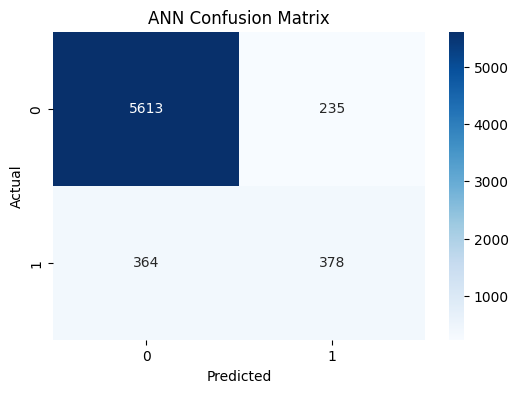

ANN Classification Report:

              precision    recall  f1-score   support

           0       0.94      0.96      0.95      5848
           1       0.62      0.51      0.56       742

    accuracy                           0.91      6590
   macro avg       0.78      0.73      0.75      6590
weighted avg       0.90      0.91      0.91      6590



In [13]:
# Predict classes on validation data
val_pred_ann = (model_ann.predict(X_val_scaled) >= 0.5).astype(int)

# Confusion matrix for ANN
cm_ann = confusion_matrix(y_val, val_pred_ann)

plt.figure(figsize=(6,4))
sns.heatmap(cm_ann, annot=True, fmt="d", cmap="Blues")
plt.title("ANN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

# Classification report (precision, recall, f1)
print("ANN Classification Report:\n")
print(classification_report(y_val, val_pred_ann))

13. Confusion Matrix for CNN

206/206 [==============================] - 0s 2ms/step


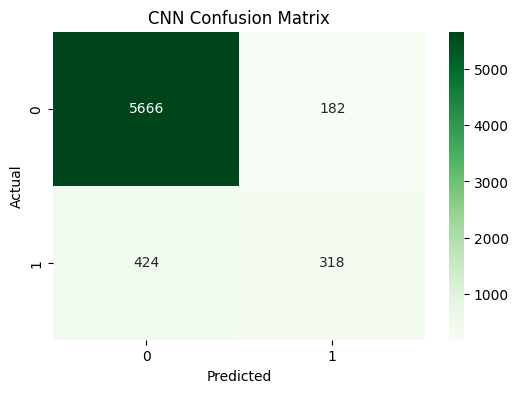

CNN Classification Report:

              precision    recall  f1-score   support

           0       0.93      0.97      0.95      5848
           1       0.64      0.43      0.51       742

    accuracy                           0.91      6590
   macro avg       0.78      0.70      0.73      6590
weighted avg       0.90      0.91      0.90      6590



In [14]:
val_pred_cnn = (model_cnn.predict(X_val_cnn) >= 0.5).astype(int)

cm_cnn = confusion_matrix(y_val, val_pred_cnn)

plt.figure(figsize=(6,4))
sns.heatmap(cm_cnn, annot=True, fmt="d", cmap="Greens")
plt.title("CNN Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.show()

print("CNN Classification Report:\n")
print(classification_report(y_val, val_pred_cnn))

14. Accuracy Graph (ANN)

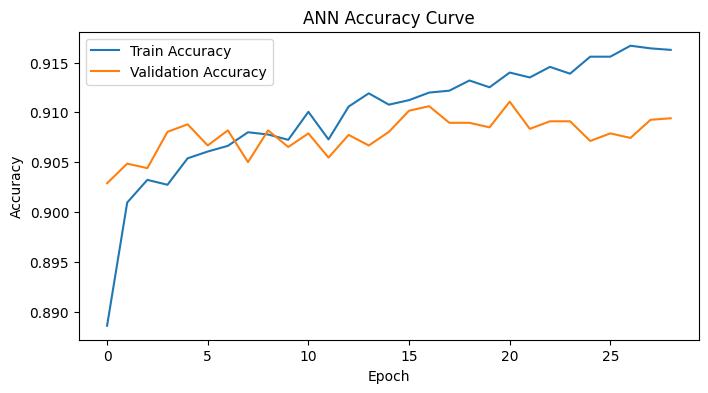

In [15]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['accuracy'], label='Train Accuracy')
plt.plot(history_ann.history['val_accuracy'], label='Validation Accuracy')
plt.title("ANN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

15. Accuracy Graph (CNN)

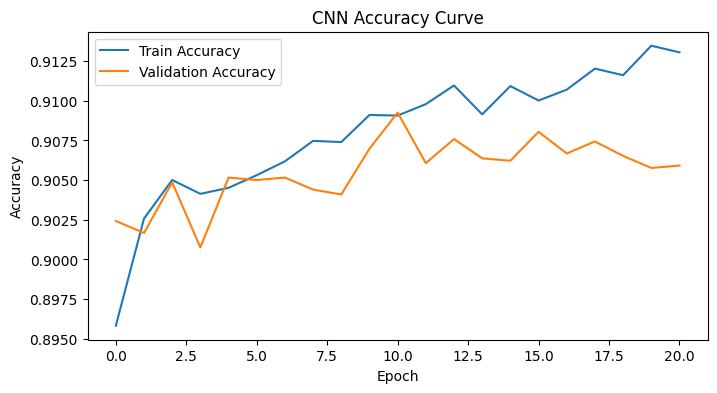

In [16]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['accuracy'], label='Train Accuracy')
plt.plot(history_cnn.history['val_accuracy'], label='Validation Accuracy')
plt.title("CNN Accuracy Curve")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

16. Loss Graph (ANN)

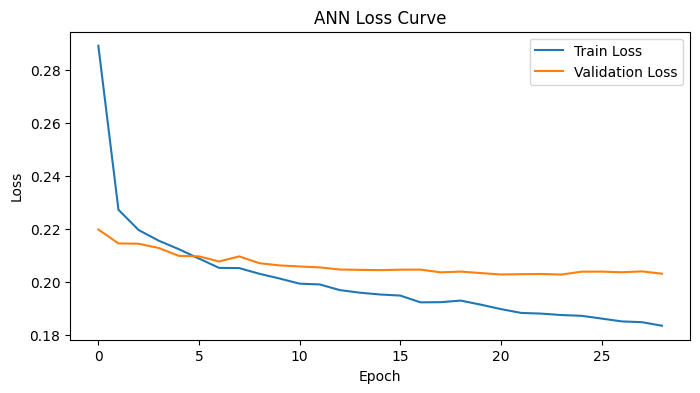

In [17]:
plt.figure(figsize=(8,4))
plt.plot(history_ann.history['loss'], label='Train Loss')
plt.plot(history_ann.history['val_loss'], label='Validation Loss')
plt.title("ANN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()

17. Loss Graph (CNN)

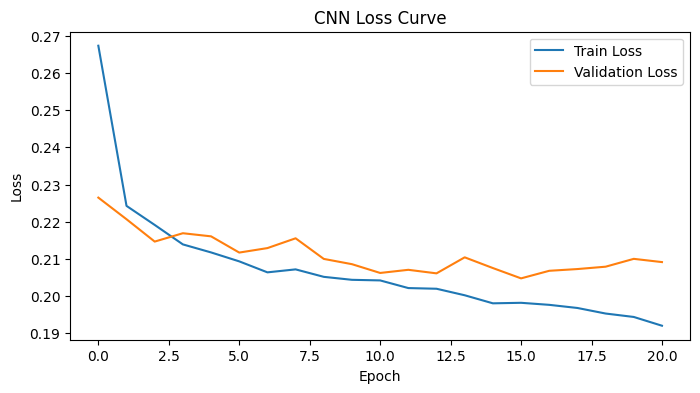

In [18]:
plt.figure(figsize=(8,4))
plt.plot(history_cnn.history['loss'], label='Train Loss')
plt.plot(history_cnn.history['val_loss'], label='Validation Loss')
plt.title("CNN Loss Curve")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.show()